## SGD for FM [STEFFEN RENDLE]
* 目标函数
$$\hat{y} = w_0 + \sum_{j=1}^{p}w_jx_j+\frac{1}{2}\sum_{f=1}^{k}[(\sum_{j=1}^{p}v_{j,f}x_j)^2-\sum_{j=1}^{p}v_{j,f}^2x_j^2]$$

* 加入正则项，防止过拟合
* Algorithm for SGD
![](img_fm/3.png)
* Gridents
$$\frac{\partial}{\partial\theta}l^{LS}(\hat{y}(\vec{x}|\vec{\theta},y)) = \frac{\partial}{\partial\theta}(\hat{y}(\vec{x}|\vec{\theta})-y)^2 = 2(\hat{y}(\vec{x}|\vec{\theta})-y)\frac{\partial}{\partial\theta}\hat{y}(\vec{x}|\vec{\theta})$$
![](img_fm/4.png)

* Little tip for Numpy and sparse matrix
> numpy's dot function does not have native support for handling sparse matrices. What is happening is numpy thinks of the sparse matrix C as a python object

### load data

In [1]:
import numpy as np
from sklearn.feature_extraction import DictVectorizer
import math
import matplotlib.pyplot as plt
# Read in data
def loadData(filename,path="ml-100k/"):
    data = []
    y = []
    users=set()
    items=set()
    with open(path+filename) as f:
        for line in f:
            (user,movieid,rating,ts)=line.split('\t')
            data.append({ "user_id": str(user), "movie_id": str(movieid)})
            y.append(float(rating))
            users.add(user)
            items.add(movieid)

    return (data, np.array(y), users, items)

### 使用SGD训练FM

In [58]:
# -*- coding: utf-8 -*-
import numpy as np
import math


class FM_SGD:
    def __init__(self,
                 iter_num,
                 learning_rate,
                 factors_num,
                 reg,
                 verbose=True):

        # 迭代次数
        self.iter_num = iter_num

        # 学习速率
        self.learning_rate = learning_rate

        # 分解器feature个数
        self.factors_num = factors_num

        # lambda
        self.reg = reg

        # 输出执行信息
        self.verbose = verbose

        # global bias
        self.w0 = 0

        # feature bias
        self.W = 0

        # feature
        self.V = 0

        # 训练过程中的mse
        self.mse = []

        # target y的最大值与最小值，for prune
        self.y_max = 0.0
        self.y_min = 0.0

    def train(self, X_, y_):

        (n, p) = X_.shape

        self.mse = []

        # global bias
        self.w0 = sum(np.random.rand(1))  # bias

        # feature bias
        self.W = np.random.rand(1, p)

        # feature
        self.V = np.random.rand(p, self.factors_num)

        self.y_max = np.max(y_)
        self.y_min = np.min(y_)

        for j in xrange(self.iter_num):

            loss_sgd = []

            # shuffle
            reidx = np.random.permutation(n)
            X_train = X_[reidx, :]
            y_train = y_[reidx]

            for i in xrange(n):

                if self.verbose and i % 1000 == 0:
                    print 'prossing ' + str(i) + 'th sample...'

                X = X_train[i, :]
                y = y_train[i]

                # too slow
                #     y_predict = (w0 + W*X.T + ((X.T*X).multiply((np.triu(V.dot(V.T),1)))).sum().sum())[0,0]

                tmp = np.sum(X.T.multiply(self.V), axis=0)
                factor_part = (np.sum(np.multiply(tmp, tmp)) - np.sum(
                    (X.T.multiply(X.T)).multiply(np.multiply(self.V, self.V)))) / 2
                y_predict = self.w0 + np.sum(self.W * X.T) + factor_part

                #                 print y_predict

                # prune
                if y_predict < self.y_min:
                    y_predict = self.y_min

                if y_predict > self.y_max:
                    y_predict = self.y_max

                diff = y_predict - y
                loss_sgd.append(math.pow(diff, 2))

                # update mse
                self.mse.append(sum(loss_sgd) / len(loss_sgd))

                # update w0
                self.w0 -= self.learning_rate * (2 * diff * 1 + 2*self.reg*self.w0)

                # update W
                self.W -= self.learning_rate * (2 * diff * X + 2*self.reg*self.W)

                # update V
                self.V -= self.learning_rate * (2 * diff * (
                    X.T.multiply((np.tile(X * self.V, (p, 1)) - X.T.multiply(self.V)))) + 2*self.reg*self.V)

    def validate(self, X_, y_):
        (n, p) = X_.shape

        mse = []
        loss_sgd = []

        for i in xrange(n):

            if self.verbose and i % 1000 == 0:
                print 'prossing ' + str(i) + 'th sample...'

            X = X_[i, :]
            y = y_[i]

            # too slow
            #     y_predict = (w0 + W*X.T + ((X.T*X).multiply((np.triu(V.dot(V.T),1)))).sum().sum())[0,0]

            tmp = np.sum(X.T.multiply(self.V), axis=0)
            factor_part = (np.sum(np.multiply(tmp, tmp)) - np.sum(
                (X.T.multiply(X.T)).multiply(np.multiply(self.V, self.V)))) / 2
            y_predict = self.w0 + np.sum(self.W * X.T) + factor_part

            #                 print y_predict

            # prune
            if y_predict < self.y_min:
                y_predict = self.y_min

            if y_predict > self.y_max:
                y_predict = self.y_max

            diff = y_predict - y
            loss_sgd.append(math.pow(diff, 2))

            # update mse
            mse.append(sum(loss_sgd) / len(loss_sgd))
        return mse


In [59]:
(train_data, y_train, train_users, train_items) = loadData("ua.base")
(test_data, y_test, test_users, test_items) = loadData("ua.test")

v = DictVectorizer()
X_train = v.fit_transform(train_data)
X_test = v.transform(test_data)
fm_sgd = FM_SGD(iter_num=1,
               learning_rate=0.01,
               factors_num=10,
               reg=0.1)
fm_sgd.train(X_train,y_train)

prossing 0th sample...
prossing 1000th sample...
prossing 2000th sample...
prossing 3000th sample...
prossing 4000th sample...
prossing 5000th sample...
prossing 6000th sample...
prossing 7000th sample...
prossing 8000th sample...
prossing 9000th sample...
prossing 10000th sample...
prossing 11000th sample...
prossing 12000th sample...
prossing 13000th sample...
prossing 14000th sample...
prossing 15000th sample...
prossing 16000th sample...
prossing 17000th sample...
prossing 18000th sample...
prossing 19000th sample...
prossing 20000th sample...
prossing 21000th sample...
prossing 22000th sample...
prossing 23000th sample...
prossing 24000th sample...
prossing 25000th sample...
prossing 26000th sample...
prossing 27000th sample...
prossing 28000th sample...
prossing 29000th sample...
prossing 30000th sample...
prossing 31000th sample...
prossing 32000th sample...
prossing 33000th sample...
prossing 34000th sample...
prossing 35000th sample...
prossing 36000th sample...
prossing 37000

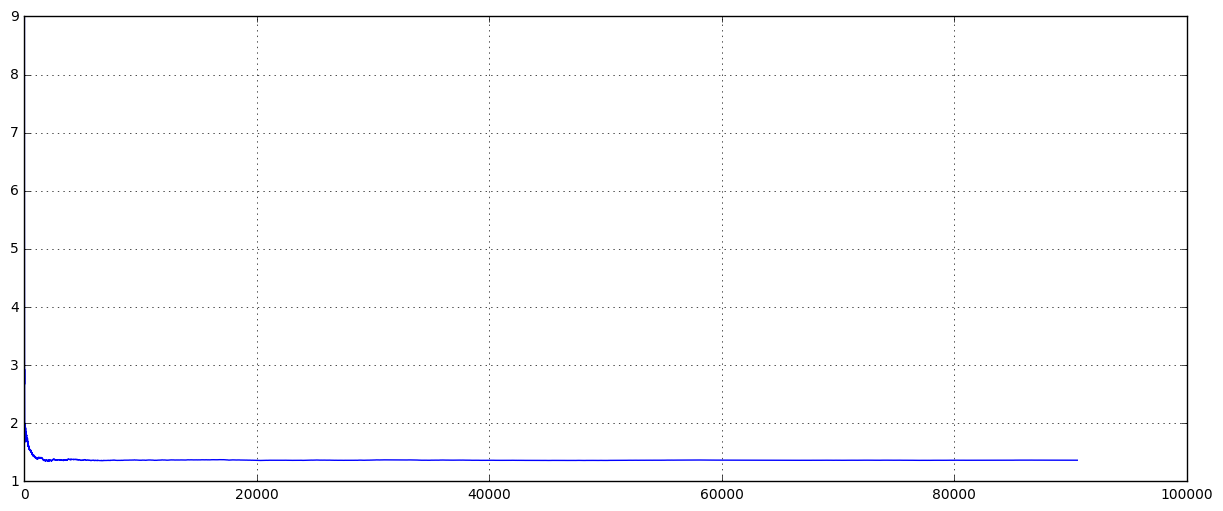

In [60]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15,6
plt.grid(True)
plt.plot(fm_sgd.mse)

### 使用ADAGRAD 训练FM

* SGD的弊端在于使用了一个恒定的全局的学习速率，无法根据feature的gradient更新速率来动态调整更新学习速率
* 为了解决这一弊端，我们为每一个参数维护一个学习速率，随着迭代次数的增加，根据总的gradient来更新学习速率

In [ ]:
class FM_ADAGRAD():
    
    def __init__(self,
                iter_num,
                learning_rate,
                factors_num,
                reg,
                verbose = True):
        
        # 迭代次数
        self.iter_num = iter_num
        
        #学习速率
        self.learning_rate = learning_rate
        
        # 分解器feature个数
        self.factors_num = factors_num
        
        # lambda
        self.reg = reg
        
        # 输出执行信息
        self.verbose = verbose
        
        # global bias
        self.w0 = 0;
        
        # feature bias
        self.W = 0;
        
        # feature
        self.V = 0;
        
        # 训练过程中的mse
        self.mse = []
        
        # target y的最大值与最小值，for prune
        self.y_max = 0.0;
        self.y_min = 0.0;
        
        
    def train(self, X_, y_):
        
        (n,p) = X_.shape
        
        self.mse = []
        
        # global bias
        self.w0 = sum(np.random.rand(1))  # bias
        
        # feature bias
        self.W = np.random.rand(1,p)
        
        # feature
        self.V = np.random.rand(p,self.factors_num)
        
        self.y_max = np.max(y_)
        self.y_min = np.min(y_)
        
        # keep track of all parameters 
        w0_gradients = 0.0;
        W_gradients = np.zeros((1,p))
        V_gradients = np.zeros((p,self.factors_num))
        
        # avoid 0 numerator
        epison = 1e-8
        
        for j in xrange(self.iter_num):
            
            loss_sgd = []

            # shuffle
            reidx = np.random.permutation(n)
            X_train = X_[reidx,:]
            y_train = y_[reidx]

            

            for i in xrange(n):

                if self.verbose and i%1000 ==0:
                    print 'prossing ' + str(i) + 'th sample...'

                X = X_train[i,:]
                y = y_train[i]

                # too slow
            #     y_predict = (w0 + W*X.T + ((X.T*X).multiply((np.triu(V.dot(V.T),1)))).sum().sum())[0,0]

                tmp = np.sum(X.T.multiply(self.V),axis=0)
                factor_part = (np.sum(np.multiply(tmp,tmp)) - np.sum((X.T.multiply(X.T)).multiply(np.multiply(self.V,self.V))))/2
                y_predict = self.w0 + np.sum(self.W*X.T) + factor_part
                
#                 print y_predict

                # prune
                if y_predict < self.y_min:
                    y_predict = self.y_min

                if y_predict > self.y_max:
                    y_predict = self.y_max

                diff = y_predict-y
                loss_sgd.append(math.pow(diff,2))

                # update mse
                self.mse.append(sum(loss_sgd)/len(loss_sgd))

                # update w0
                gradient = 2*diff * (1)
                w0_gradients += np.square(gradient)
                self.w0 = self.w0 - self.learning_rate/np.sqrt(w0_gradients+epison)*gradient
                
                
                # update W
                gradient = 2*diff * (X)
                W_gradients += gradient.multiply(gradient)
                self.W = self.W - gradient.multiply(self.learning_rate/np.sqrt(W_gradients+epison))
                
#                 print W_gradients.shape
#                 print gradient.shape
                
                
                
                # update V
                gradient = 2*diff* (X.T.multiply((np.tile(X*self.V,(p,1)) - X.T.multiply(self.V))))
                V_gradients += np.multiply(gradient,gradient)
                self.V = self.V - np.multiply(self.learning_rate/np.sqrt(V_gradients+epison),gradient)
                

    def validate(self, X_, y_):
        (n,p) = X_.shape
        
        mse = []
        

        for i in xrange(n):

            if self.verbose and i%1000 ==0:
                print 'prossing ' + str(i) + 'th sample...'

            X = X_train[i,:]
            y = y_train[i]

            # too slow
        #     y_predict = (w0 + W*X.T + ((X.T*X).multiply((np.triu(V.dot(V.T),1)))).sum().sum())[0,0]

            tmp = np.sum(X.T.multiply(self.V),axis=0)
            factor_part = (np.sum(np.multiply(tmp,tmp)) - np.sum((X.T.multiply(X.T)).multiply(np.multiply(self.V,self.V))))/2
            y_predict = self.w0 + np.sum(self.W*X.T) + factor_part

#                 print y_predict

            # prune
            if y_predict < self.y_min:
                y_predict = self.y_min

            if y_predict > self.y_max:
                y_predict = self.y_max

            diff = y_predict-y
            loss_sgd.append(math.pow(diff,2))

            # update mse
            mse.append(sum(loss_sgd)/len(loss_sgd))
        return mse

In [ ]:
(train_data, y_train, train_users, train_items) = loadData("ua.base")
(test_data, y_test, test_users, test_items) = loadData("ua.test")

v = DictVectorizer()
X_train = v.fit_transform(train_data)
X_test = v.transform(test_data)
fm_adagrad = FM_ADAGRAD(iter_num=1,
               learning_rate=0.1,
               factors_num=10,
               reg=0.1)
fm_adagrad.train(X_train,y_train)

In [ ]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15,6
plt.grid(True)
plt.plot(fm_adagrad.mse)

In [ ]:
fm_adagrad.W

## Local Linear Factorization Machines

In [40]:
# -*- coding: utf-8 -*-
import math

import numpy as np
from sklearn.cluster import KMeans


class LLFM_SGD:
    def __init__(self,
                 iter_num,
                 learning_rate,
                 factors_num,
                 reg,
                 anchor_num,
                 neighbor_num,
                 verbose=True):

        # 迭代次数
        self.iter_num = iter_num

        # 学习速率
        self.learning_rate = learning_rate

        # 分解器feature个数
        self.factors_num = factors_num

        # lambda
        self.reg = reg

        # 输出执行信息
        self.verbose = verbose

        # global bias
        self.w0 = 0

        # feature bias
        self.W = 0

        # feature
        self.V = 0

        # 训练过程中的mse
        self.mse = []

        # target y的最大值与最小值，for prune
        self.y_max = 0.0
        self.y_min = 0.0

        # anchor point 的个数
        self.anchor_num = anchor_num

        # find k-nearest anchor points
        self.neighbor_num = neighbor_num

        # anchor point
        self.anchor_points = np.array([0])

    def knn(self, x):
        dist = np.linalg.norm(self.anchor_points - x, axis=1)
        idx = np.argsort(dist)
        dist = np.exp(-dist[idx[:self.neighbor_num]])
        gamma = dist / np.sum(dist)
        return gamma, idx[:self.neighbor_num]

    def train(self, X_, y_):

        (n, p) = X_.shape

        self.mse = []

        # anchor bias
        self.w0 = np.random.rand(self.anchor_num, 1)

        # feature bias
        #         self.W = np.random.rand(1,p)
        # local coding
        self.W = np.random.rand(self.anchor_num, p)

        # feature
        self.V = np.random.rand(p, self.factors_num)

        self.y_max = np.max(y_)
        self.y_min = np.min(y_)

        if self.verbose:
            print 'performing K-means...'

        # K-means get anchor points

        kmeans = KMeans(n_clusters=self.anchor_num, random_state=0).fit(X_)
        self.anchor_points = kmeans.cluster_centers_

        if self.verbose:
            print 'K-means done...'

        for j in xrange(self.iter_num):

            loss_sgd = []

            # shuffle
            re_idx = np.random.permutation(n)
            x_train = X_[re_idx, :]
            y_train = y_[re_idx]

            for i in xrange(n):

                if self.verbose and i % 1000 == 0:
                    print 'processing ' + str(i) + 'th sample...'

                X = x_train[i, :]
                y = y_train[i]

                (gamma, idx) = self.knn(X)

                # if self.verbose:
                #     print 'k-nearest neighbors found...'

                tmp = np.sum(X.T.multiply(self.V), axis=0)
                factor_part = (np.sum(np.multiply(tmp, tmp)) - np.sum(
                    (X.T.multiply(X.T)).multiply(np.multiply(self.V, self.V)))) / 2
                y_predict = np.dot(gamma, self.w0[idx]) + np.dot(gamma, np.dot(self.W[idx, :], X.toarray().T)) + factor_part

                # prune
                if y_predict < self.y_min:
                    y_predict = self.y_min

                if y_predict > self.y_max:
                    y_predict = self.y_max

                diff = np.sum(y_predict - y)
                loss_sgd.append(math.pow(diff, 2))

                # update mse
                self.mse.append(sum(loss_sgd) / len(loss_sgd))

                # update w0
                gamma = np.array([gamma])
                self.w0[idx, :] -= self.learning_rate * 2 * diff * gamma.T

                # update W
                self.W[idx, :] -= self.learning_rate * 2 * diff * np.dot(gamma.T, X.toarray())

                # update V
                self.V -= self.learning_rate * 2 * diff * (
                    X.T.multiply((np.tile(X * self.V, (p, 1)) - X.T.multiply(self.V))))

    def validate(self, x_, y_):
        (n, p) = x_.shape

        mse = []
        loss_sgd = []

        for i in xrange(n):

            if self.verbose and i % 1000 == 0:
                print 'processing ' + str(i) + 'th sample...'

            x = x_[i, :]
            y = y_[i]

            tmp = np.sum(x.T.multiply(self.V), axis=0)
            factor_part = (np.sum(np.multiply(tmp, tmp)) - np.sum(
                (x.T.multiply(x.T)).multiply(np.multiply(self.V, self.V)))) / 2
            y_predict = self.w0 + np.sum(self.W * x.T) + factor_part

            # prune
            if y_predict < self.y_min:
                y_predict = self.y_min

            if y_predict > self.y_max:
                y_predict = self.y_max

            diff = y_predict - y
            loss_sgd.append(math.pow(diff, 2))

            # update mse
            mse.append(sum(loss_sgd) / len(loss_sgd))
        return mse


In [57]:
(train_data, y_train, train_users, train_items) = loadData("ua.base")
(test_data, y_test, test_users, test_items) = loadData("ua.test")

v = DictVectorizer()
X_train = v.fit_transform(train_data)
X_test = v.transform(test_data)
llfm_sgd = LLFM_SGD(iter_num=1,
                    learning_rate=0.5,
                    factors_num=10,
                    reg=0.1,
                    anchor_num = 100,
                    neighbor_num = 5
                   )
llfm_sgd.train(X_train,y_train)

performing K-means...
K-means done...
processing 0th sample...
processing 1000th sample...
processing 2000th sample...
processing 3000th sample...
processing 4000th sample...
processing 5000th sample...
processing 6000th sample...
processing 7000th sample...
processing 8000th sample...
processing 9000th sample...
processing 10000th sample...
processing 11000th sample...
processing 12000th sample...
processing 13000th sample...
processing 14000th sample...
processing 15000th sample...
processing 16000th sample...
processing 17000th sample...
processing 18000th sample...
processing 19000th sample...
processing 20000th sample...
processing 21000th sample...
processing 22000th sample...
processing 23000th sample...
processing 24000th sample...
processing 25000th sample...
processing 26000th sample...
processing 27000th sample...
processing 28000th sample...
processing 29000th sample...
processing 30000th sample...
processing 31000th sample...
processing 32000th sample...
processing 33000th

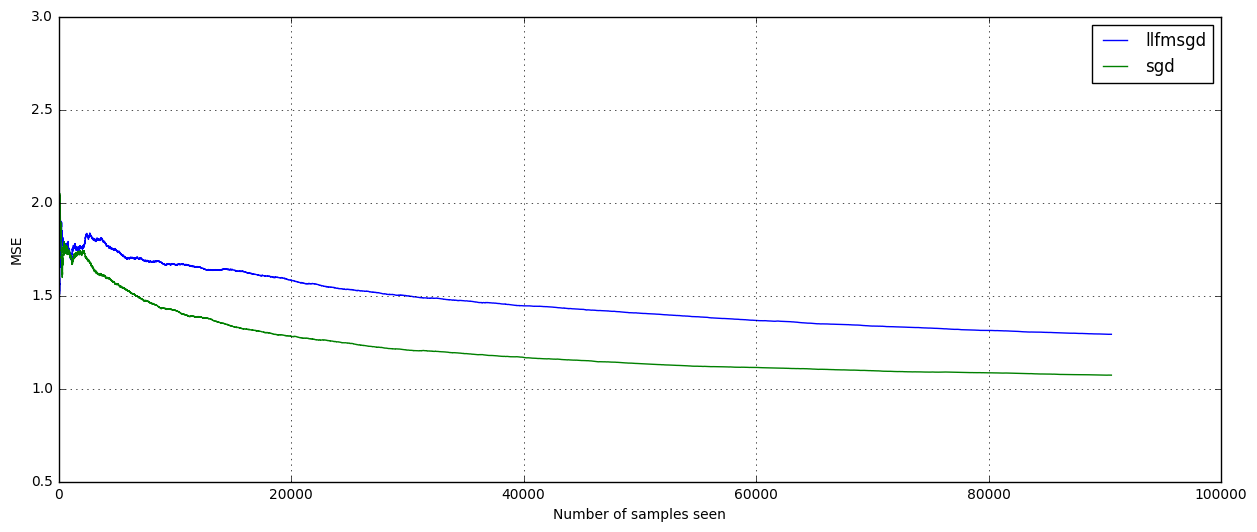

In [54]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15,6
plt.grid(True)
plt.plot(llfm_sgd.mse)
plt.plot(fm_sgd.mse)
plt.legend(['llfmsgd','sgd'])
plt.xlabel('Number of samples seen')
plt.ylabel('MSE')
plt.show()